# Coronavirus Scatter


In [49]:
import datetime
import itertools
from pprint import pprint
from pathlib import Path
import time
import timeit

from IPython.display import HTML 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import numpy as np
import pandas as pd
from pandas import to_datetime
import plotly.express as px
from scipy.special import gamma
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_regression

from coronavirus.data import (
    add_derived_values_cols,
    before_threshold,
    load_covidtracking_state_data,
    load_ecdc_country_data,
)
from coronavirus.util import fit_power_law


%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Load Data

In [2]:
# takes 20 seconds
states_df = (load_covidtracking_state_data(download=False, cache=True)
             .pipe(add_derived_values_cols))
countries_df = (load_ecdc_country_data(download=False, cache=True)
                .pipe(add_derived_values_cols))


## Plot Cases Then Versus Deaths Now

Inspiration: [UK suffers second-highest death rate from coronavirus | Free to read](https://www.ft.com/content/6b4c784e-c259-4ca4-9a82-648ffde71bf0) from the Financial Times.


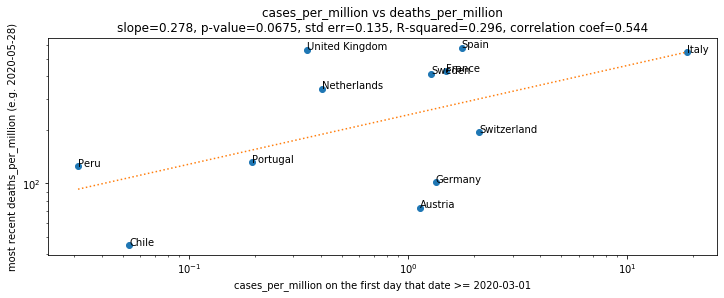

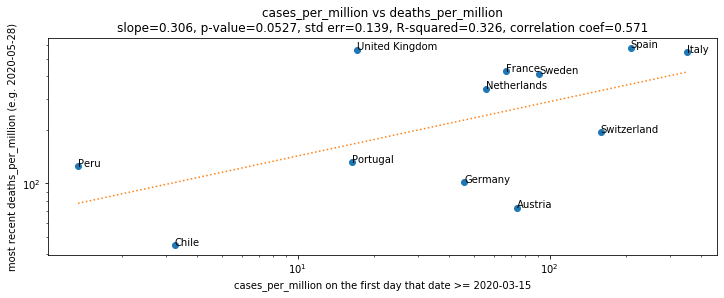

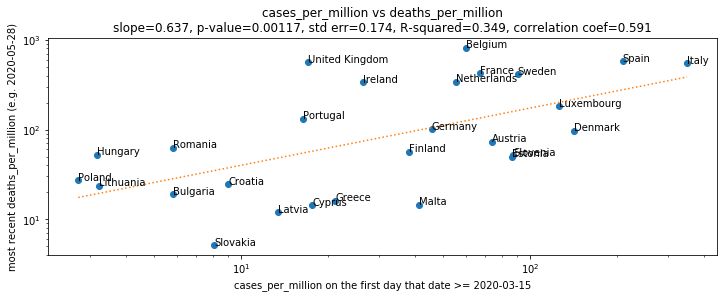

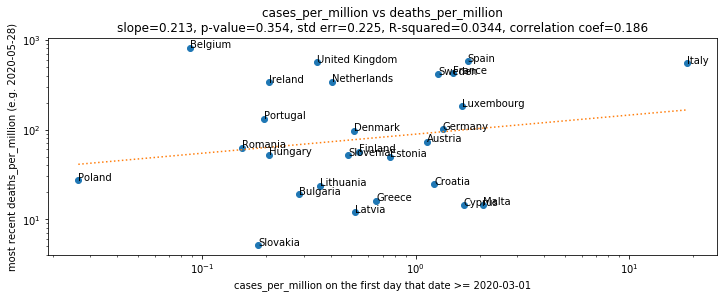

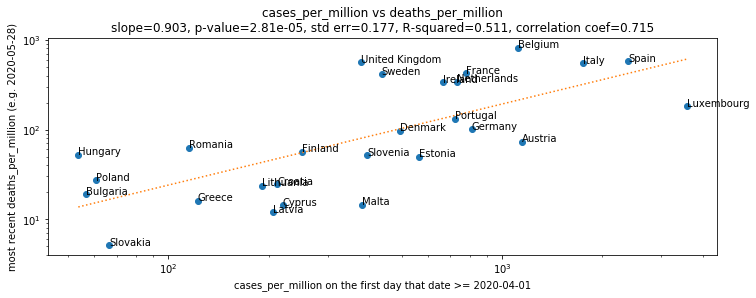

In [83]:
# since_col = 'date'; since_thresh = pd.to_datetime('2020-03-15')
# since_col = 'date'; since_thresh = pd.to_datetime('2020-04-01')
# since_col = 'cases_per_million'; since_thresh = 100
# since_col = 'cases_per_million'; since_thresh = 400
then_col = 'cases_per_million'; now_col = 'deaths_per_million'

# since_col = 'cases'; since_thresh = 10000
# then_col = 'cases'; now_col = 'deaths'

entities = ['Peru', 'Netherlands', 'Chile', 'Germany', 'Switzerland', 'Portugal', 
            'United Kingdom', 'France', 'Austria', 'US', 'Spain', 'Italy', 'Sweden',
           ]

def plot_scatter(df, then_col, now_col, since_col, since_thresh, entities=None):
    if entities:
        df = df.loc[df['entity'].isin(entities), :]
        
    df = df.loc[~before_threshold(df, col=since_col, thresh=since_thresh), :]
    grouped = df.groupby(['entity'])
    ents = list(grouped[then_col].first().index)
    then_values = grouped[then_col].apply(lambda s: s[s.notna()].values[0])
    now_values = grouped[now_col].last()
    now_date = grouped['date'].last().max()

#     for ent, then_val, now_val in zip(ents, then_values, now_values):
#         print(ent, then_val, now_val)

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.loglog(then_values, now_values, 'o')
    (xmin, xmax, slope, intercept, p_value, std_err, r_value, 
     r_squared, pred_x, pred_y) = fit_power_law(
        then_values, now_values)
    plt.loglog(pred_x, pred_y, ':', label=f"linear model")
    since_thresh_label = since_thresh.strftime("%Y-%m-%d") if isinstance(since_thresh, datetime.datetime) else since_thresh
    ax.set_xlabel(f'{then_col} on the first day that {since_col} >= {since_thresh_label}')
    ax.set_ylabel(f'most recent {now_col} (e.g. {now_date.strftime("%Y-%m-%d")})')
    for ent, then_val, now_val in zip(ents, then_values, now_values):
        ax.annotate(ent, xy=(then_val, now_val))
    ax.set_title(f'{then_col} vs {now_col}\n' + 
                 f'slope={slope:.3}, p-value={p_value:.3}, std err={std_err:.3}' +
                 f', R-squared={r_squared:.3}, correlation coef={r_value:.3}')
    plt.show()


df = countries_df
since_col = 'date'; since_thresh = pd.to_datetime('2020-03-01')
# then_col = 'cases'; now_col = 'deaths'
# plot_scatter(df, then_col, now_col, since_col, since_thresh, entities)
# plot_scatter(df, then_col, now_col, since_col, since_thresh, entities + ['Norway'])
then_col = 'cases_per_million'; now_col = 'deaths_per_million'
plot_scatter(df, then_col, now_col, since_col, since_thresh, entities)
# plot_scatter(df, then_col, now_col, since_col, since_thresh, entities + ['Norway'])

since_col = 'date'; since_thresh = pd.to_datetime('2020-03-15')
# then_col = 'cases'; now_col = 'deaths'
# plot_scatter(df, then_col, now_col, since_col, since_thresh, entities)
# plot_scatter(df, then_col, now_col, since_col, since_thresh, entities + ['Norway'])
then_col = 'cases_per_million'; now_col = 'deaths_per_million'
plot_scatter(df, then_col, now_col, since_col, since_thresh, entities)
# plot_scatter(df, then_col, now_col, since_col, since_thresh, entities + ['Norway'])

# since_col = 'date'; since_thresh = pd.to_datetime('2020-04-01')
# then_col = 'cases'; now_col = 'deaths'
# plot_scatter(df, then_col, now_col, since_col, since_thresh, entities)
# plot_scatter(df, then_col, now_col, since_col, since_thresh, entities + ['Norway'])
# then_col = 'cases_per_million'; now_col = 'deaths_per_million'
# plot_scatter(df, then_col, now_col, since_col, since_thresh, entities)
# plot_scatter(df, then_col, now_col, since_col, since_thresh, entities + ['Norway'])

since_col = 'date'; since_thresh = pd.to_datetime('2020-03-15')
then_col = 'cases_per_million'; now_col = 'deaths_per_million'
from coronavirus.data import eu_countries_ecdc
entities = set(eu_countries_ecdc + ['United Kingdom']) - set(['Czechia']) # czechia has 0 cases on 3/1
plot_scatter(df, then_col, now_col, since_col, since_thresh, entities)
since_col = 'date'; since_thresh = pd.to_datetime('2020-03-01')
plot_scatter(df, then_col, now_col, since_col, since_thresh, entities)
since_col = 'date'; since_thresh = pd.to_datetime('2020-04-01')
plot_scatter(df, then_col, now_col, since_col, since_thresh, entities)


